本篇笔记的内容主要是围绕着模型的评估和优化开展，包括以下内容：1)模型性能的无偏估计；2)处理机器学习算法中的常见问题；3)机器学习模型调优；4)使用不同的性能指标评估预测模型。

##### 1.使用pandas从UCI网站直接读取数据集

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


##### 2.使用LabelEncoder类将原始的用字符串表示的类标转换为整数。

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values # 将数据集的30个特征赋给numpy ndarray
y = df.loc[:, 1].values  # 将类标赋给y,此时的类标还是字符串
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
le.transform(['M', 'B']) # M被转换成类标1，B被转换为类标0

array([1, 0], dtype=int64)

划分数据集

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
                            train_test_split(X, y, test_size=0.20, random_state=1)

##### 3.对数据做标准化处理，然后通过主成分分析(PCA)技术，将30维的特征压缩到一个二维子空间上，然后训练logistic回归模型并进行模型测试。

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('sc1', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', LogisticRegression(solver='sag', random_state=1))])

pipe_lr.fit(X_train, y_train)
print('The Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

The Accuracy: 0.947


##### 4.采用分层k折交叉验证来选择模型

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold  # cross_validation模块已经被弃用

s_kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)

scores = []
k=0
for train_index, test_index in s_kfold.split(X_train, y_train):
    pipe_lr.fit(X_train[train_index], y_train[train_index])
    score = pipe_lr.score(X_train[test_index], y_train[test_index])
    scores.append(score)
    print('Fole: %s, Class dist:  %s, Acc: %.3f ' % (k+1, np.bincount(y_train[train_index]), score) )
    k += 1
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fole: 1, Class dist:  [256 153], Acc: 0.913 
Fole: 2, Class dist:  [256 153], Acc: 0.978 
Fole: 3, Class dist:  [256 153], Acc: 0.978 
Fole: 4, Class dist:  [256 153], Acc: 0.913 
Fole: 5, Class dist:  [256 153], Acc: 0.935 
Fole: 6, Class dist:  [257 153], Acc: 0.978 
Fole: 7, Class dist:  [257 153], Acc: 0.933 
Fole: 8, Class dist:  [257 153], Acc: 0.956 
Fole: 9, Class dist:  [257 153], Acc: 0.978 
Fole: 10, Class dist:  [257 153], Acc: 0.956 
CV accuracy: 0.952 +/- 0.025


In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('CV scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # np.std()计算的是标准差

CV scores: [0.91304348 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV accuracy: 0.952 +/- 0.025


##### 5.绘制出学习曲线，判断模型的偏差和方差问题

[ 40  81 122 163 204 245 286 327 368 409]
(10, 10)
(10, 10)


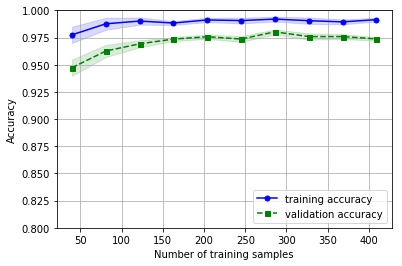

In [55]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000))])

'''
函数返回的rain_sizes是每个训练子集的数量，先将训练集划分了训练子集，然后再在训练子集上执行k折交叉验证。
train_scores是训练集的准确率，test_scores是测试集的准确率。在此例子中，两者皆是10x10的数组。
'''
train_sizes, train_scores, test_scores = \
          learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

print(train_sizes)
print(train_scores.shape)
print(test_scores.shape)

train_mean = np.mean(train_scores, axis=1) # 在axis=1轴上求均值，就是求一个训练子集下k折交叉验证的平均准确率
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue') # 此函数用于加入标准差的信息
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + train_std, test_mean - train_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

注：图中的横轴是训练子集的样本数量，纵轴是准确率。从图中可以看出，验证集的准确率仍然低于训练集，说明模型略微有些过拟合，这种情况下可以通过增加训练集的数据来减少过拟合。

##### 6.绘制验证曲线判定模型是否过拟合还是欠拟合

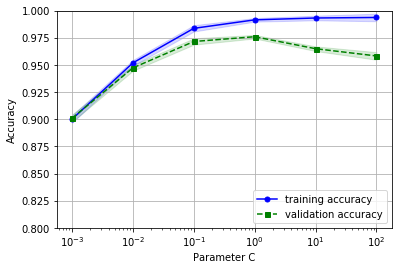

In [9]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='clf__C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + train_std, test_mean - train_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

注：参数C的倒数代表正则化的强度。从图中可以看出，C值较小时，即正则化强度较大时，会导致模型出现轻微的欠拟合。C值较大时，即正则化强度较小时，会导致模型出现过拟合。本例中，C值的最优点在0.1附近，此时模型具有较小的偏差和方差。

##### 7.使用网格搜索调优机器学习模型

在机器学习中，有两类参数，一类是通过训练数据学习得到的参数，如logistic回归中的回归系数；另一类是需要单独进行优化的超参数。网格搜索技术能够寻找最优的超参数的组合，从而进一步提高模型的性能。

通过对我们指定的不同的超参数列表进行穷举搜索，并计算评估每一个组合对模型性能的影响，以获得参数的最优组合。

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

c_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
g_range = [0.125, 0.25, 0.5 ,1, 2, 4]
param_grid = [{'clf__C': c_range, 'clf__kernel': ['linear']}, {'clf__C': c_range, 'clf__kernel': ['rbf'], 'clf__gamma': g_range}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', iid=True, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [11]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('The accuracy: %.3f' % clf.score(X_test, y_test))

The accuracy: 0.965


##### 8.嵌套交叉验证

In [12]:
gs = GridSearchCV(estimator= pipe_svc, param_grid=param_grid, scoring='accuracy', iid=True, cv=10, n_jobs=-1)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.007


In [13]:
from sklearn.tree import DecisionTreeClassifier
'''
此处param_grid是列表(元素是字典)或者字典，并且字典的键必须是estimator定义的评估器的参数，也就是需要组合调优的参数。
'''
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}, iid=True, scoring='accuracy', cv=5)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.908 +/- 0.045


##### 9.衡量模型相关性能的指标还包括以下几种：准确率，召回率，F1分数等。

读取<font color=red>**混淆矩阵**</font>。混淆矩阵是一个2x2的方阵，存储的是分类器的预测结果，分别为真正，真负，假正，假负。

In [47]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


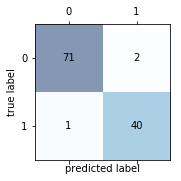

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

打印出准确率、召回率和F1分数。

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred)) # y_test测试集数据的类标，y_pred是模型对测试集数据的预测类标
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


##### 10.绘制ROC曲线

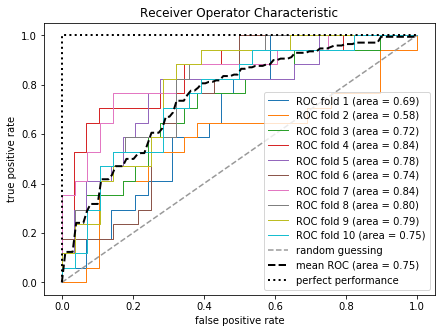

In [63]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr= 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

k = 0
for train_index, test_index in cv.split(X_train2, y_train):
    probas = pipe_lr.fit(X_train2[train_index], y_train[train_index]).predict_proba(X_train2[test_index])
    fpr, tpr, thresholds = roc_curve(y_train[test_index], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (k+1, roc_auc))
    k += 1

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

mean_tpr /= k
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', lw=2, label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [68]:
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print('ROC AUC:  %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy:  %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC:  0.671
Accuracy:  0.728


总结：在本篇笔记的开始，讨论了通过便捷的流水线模型串联不同的数据转换技术与分类器，以帮助我们更高效地训练与评估机器学习模型。进而学会用k折交叉验证选择及评估模型。绘制了学习曲线以及验证曲线来诊断算法是否发生过拟合于欠拟合等问题。使用网格搜索技术对模型进一步微调，最后学习了混淆矩阵以及各种不同性能评价指标。